**Down Load DataSet**

In [1]:
from google.colab import drive
drive.mount('/content/gdriv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdriv


**Unzip Dataset**

In [0]:
# !unzip "./gdrive/My Drive/A_05_Part_02_Dataset.zip" -d "./gdrive/My Drive"

**Import Libraries**

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import f1_score

import  numpy as np
from tqdm import notebook
from tqdm import tqdm

**Load Data**

In [0]:
data_dir = '/content/gdriv/My Drive/A_05_Part_02_Dataset'

In [4]:

#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=valid_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,num_workers=2,pin_memory=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=16, shuffle=True,num_workers=2,pin_memory=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


**One_Hot_encoding Function**

In [0]:
def one_hot_encode(X):
  OneHot = []
  for label in X:
    if label == 0:
      OneHot.append([1., 0., 1.])
    if label == 1:
      OneHot.append([0., 1., 0.])
    if label == 2:
      OneHot.append([0., 0., 1.])

  return torch.FloatTensor(OneHot)

**Focal Loss Function**

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCEL = nn.BCEWithLogitsLoss()
        BCE_loss = BCEL(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = (1-pt)**self.gamma * BCE_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

**Training Function**

In [0]:
def training_fun(model,Epochs, optimizer, output_file_name,Criterion=nn.BCEWithLogitsLoss(),isFocal = False ):
  #if you have gpu then you need to convert the network and data to cuda
  #the easiest way is to first check for device and then convert network and data to device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  model.train()
  lossEpochs = []
  accEpochs = []
  lossValid = []
  accValid = []
  for epoch in range(Epochs):  # loop over the dataset multiple times
      correct = 0
      total = 0
      running_loss = 0.0
      pbar = tqdm(enumerate(trainloader))
      for i, data in pbar:
          # get the inputs
          inputs, original_labels = data
          labels = one_hot_encode(original_labels)
          inputs, labels = inputs.to(device), labels.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
          # because PyTorch accumulates the gradients on subsequent backward passes. 
          # This is convenient while training RNNs. 
          # So, the default action is to accumulate the gradients on every loss.backward() call

          # forward + backward + optimize
          outputs = model(inputs)               #----> forward pass
          if isFocal==False:
            loss = Criterion(outputs, labels)   #----> compute loss
          else:
            FL =  FocalLoss()
            loss = FL.forward(outputs,labels)   #----> compute loss
          loss.backward()                     #----> backward pass
          optimizer.step()                    #----> weights update

          sig = nn.Sigmoid()
          val = sig(outputs)
          val[val>=0.5]=1
          val[val<0.5]=0
          total += labels.size(0)

          c_count=0
          for j in range(0,labels.size(0)):
            if(val[j]==labels[j]).sum().item()==3:
              c_count+=1
              correct+=1
          # print statistics
          running_loss += loss.item()
          
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tCorrect: {}\tTotal: {}'.format(
                  epoch, i * len(inputs), len(trainloader.dataset),
                  100. * i / len(trainloader),
                  loss.data.item(),c_count,labels.size(0)))
          

      acc = 100 * correct / total
      print('Training Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
      lossEpochs.append(running_loss)
      accEpochs.append(acc)

      # # Validation Accuracy and Loss
      correct = 0
      total = 0
      valid_loss = 0.0
      confusionMatrix = np.zeros((2, 2));
      with torch.no_grad():
          for valid_data in validloader:
              images, original_labels = data
              labels =  one_hot_encode(original_labels)
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              if isFocal==False:
                valid_losss = Criterion(outputs, labels)   #----> compute loss
              else:
                FL =  FocalLoss()
                valid_losss = FL.forward(outputs,labels)   #----> compute loss
              sig = nn.Sigmoid()
              val = sig(outputs)
              val[val>=0.5]=1.
              val[val<0.5]=0.
              # _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              c_count = 0
              for j in range(0,labels.size(0)):
                if(val[j]==labels[j]).sum()==3:
                  c_count+=1
                  correct+=1
      acc = 100 * correct / total
      print('Validation Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
      lossValid.append(valid_loss)
      accValid.append(acc)
      torch.save(model.state_dict(), '/content/gdriv/My Drive/'+output_file_name)
  plt.plot(lossEpochs)
  plt.plot(lossValid)
  plt.xlabel("No. of Epochs")
  plt.ylabel("Cross Entropy Loss")
  plt.show()

  plt.plot(accEpochs)
  plt.plot(accValid)
  plt.xlabel("No. of Epochs")
  plt.ylabel("Accuracy")
  plt.show()
  print('Finished Training')

**Testing Function**

In [0]:
def testing_fun(model,dataset):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  correct = 0
  total = 0
  predicted_List=[]
  labels_List=[]
  predicted_cuda_List=[]
  labels_cuda_List=[]
  with torch.no_grad():
      for data in dataset:
          images, original_labels = data
          labels = one_hot_encode(original_labels)
          images, labels = images.to(device), labels.to(device)
          labels_cuda_List.append(labels)
          outputs = model(images)
          sig = nn.Sigmoid()
          val = sig(outputs)
          val[val>=0.5]=1
          val[val<0.5]=0
          predicted_cuda_List.append(val)
          total += labels.size(0)
          c_count = 0
          for j in range(0,labels.size(0)):
            if(val[j]==labels[j]).sum()==3:
              c_count+=1
              correct+=1

  for x in labels_cuda_List:
    for y in x:
      labels_List.append(y.cpu().numpy())
  for x in predicted_cuda_List:
    for y in x:
      predicted_List.append(y.cpu().numpy())

  labels_List = np.asarray(labels_List)
  predicted_List = np.asarray(predicted_List)
  F1_Score = f1_score(y_true = labels_List, y_pred= predicted_List, average='weighted')
  conf_matrix = multilabel_confusion_matrix(labels_List,predicted_List)
  acc = 100 * correct / total
  print('Accuracy ', acc)
  print('F1 Score ', F1_Score)
  print('Covid19\n ', conf_matrix[0])
  print('Normal\n  ',  conf_matrix[1])
  print('Pneumonia\n ',conf_matrix[2])

**Load VGGG16 Model**

In [12]:
vgg16 = models.vgg16(pretrained=False)
fl_neu_inp = vgg16.classifier[0].in_features
features = list(vgg16.classifier)[:-7]
features
features.extend(
    [
     nn.Linear(fl_neu_inp,460),
     nn.ReLU(inplace=True),
     nn.Dropout(inplace=False),
     nn.Linear(460, len(class_names))])
vgg16.classifier = nn.Sequential(*features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


**Set Hyper Parameters**

In [0]:
Epochs = 15
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

**Train Model With Out Focal Loss Using VGG16**


0it [00:00, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.237923	Correct: 28	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.237923	Correct: 28	Total: 32: : 1it [00:01,  1.48s/it]
Train Epoch: 0 [32/6200 (1%)]	Loss: 0.181863	Correct: 27	Total: 32: : 1it [00:01,  1.48s/it]
Train Epoch: 0 [32/6200 (1%)]	Loss: 0.181863	Correct: 27	Total: 32: : 2it [00:01,  1.17s/it]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.230989	Correct: 27	Total: 32: : 2it [00:02,  1.17s/it]
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.230989	Correct: 27	Total: 32: : 3it [00:02,  1.10s/it]
Train Epoch: 0 [96/6200 (2%)]	Loss: 0.305860	Correct: 24	Total: 32: : 3it [00:03,  1.10s/it]
Train Epoch: 0 [96/6200 (2%)]	Loss: 0.305860	Correct: 24	Total: 32: : 4it [00:03,  1.11it/s]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.409814	Correct: 27	Total: 32: : 4it [00:04,  1.11it/s]
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.409814	Correct: 27	Total: 32: : 5it [00:04,  1.02it/s]
Train Epoch: 0 [160/6200 (3%)]	Loss: 0.152529	Correct:

Training Accuracy of Epoch 0: 84 %


Validation Accuracy of Epoch 0: 80 %



0it [00:00, ?it/s]
Train Epoch: 1 [0/6200 (0%)]	Loss: 0.130168	Correct: 29	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 1 [0/6200 (0%)]	Loss: 0.130168	Correct: 29	Total: 32: : 1it [00:01,  1.60s/it]
Train Epoch: 1 [32/6200 (1%)]	Loss: 0.119120	Correct: 30	Total: 32: : 1it [00:02,  1.60s/it]
Train Epoch: 1 [32/6200 (1%)]	Loss: 0.119120	Correct: 30	Total: 32: : 2it [00:02,  1.26s/it]
Train Epoch: 1 [64/6200 (1%)]	Loss: 0.299277	Correct: 26	Total: 32: : 2it [00:03,  1.26s/it]
Train Epoch: 1 [64/6200 (1%)]	Loss: 0.299277	Correct: 26	Total: 32: : 3it [00:03,  1.18s/it]
Train Epoch: 1 [96/6200 (2%)]	Loss: 0.274552	Correct: 28	Total: 32: : 3it [00:03,  1.18s/it]
Train Epoch: 1 [96/6200 (2%)]	Loss: 0.274552	Correct: 28	Total: 32: : 4it [00:03,  1.04it/s]
Train Epoch: 1 [128/6200 (2%)]	Loss: 0.369835	Correct: 25	Total: 32: : 4it [00:04,  1.04it/s]
Train Epoch: 1 [128/6200 (2%)]	Loss: 0.369835	Correct: 25	Total: 32: : 5it [00:04,  1.07it/s]
Train Epoch: 1 [160/6200 (3%)]	Loss: 0.205732	Correct:

Training Accuracy of Epoch 1: 86 %


Validation Accuracy of Epoch 1: 91 %



0it [00:00, ?it/s]
Train Epoch: 2 [0/6200 (0%)]	Loss: 0.134301	Correct: 29	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 2 [0/6200 (0%)]	Loss: 0.134301	Correct: 29	Total: 32: : 1it [00:01,  1.51s/it]
Train Epoch: 2 [32/6200 (1%)]	Loss: 0.141460	Correct: 28	Total: 32: : 1it [00:01,  1.51s/it]
Train Epoch: 2 [32/6200 (1%)]	Loss: 0.141460	Correct: 28	Total: 32: : 2it [00:01,  1.20s/it]
Train Epoch: 2 [64/6200 (1%)]	Loss: 0.248049	Correct: 27	Total: 32: : 2it [00:03,  1.20s/it]
Train Epoch: 2 [64/6200 (1%)]	Loss: 0.248049	Correct: 27	Total: 32: : 3it [00:03,  1.18s/it]
Train Epoch: 2 [96/6200 (2%)]	Loss: 0.275905	Correct: 25	Total: 32: : 3it [00:04,  1.18s/it]
Train Epoch: 2 [96/6200 (2%)]	Loss: 0.275905	Correct: 25	Total: 32: : 4it [00:04,  1.10s/it]
Train Epoch: 2 [128/6200 (2%)]	Loss: 0.161739	Correct: 29	Total: 32: : 4it [00:04,  1.10s/it]
Train Epoch: 2 [128/6200 (2%)]	Loss: 0.161739	Correct: 29	Total: 32: : 5it [00:04,  1.08it/s]
Train Epoch: 2 [160/6200 (3%)]	Loss: 0.114144	Correct:

Training Accuracy of Epoch 2: 87 %


Validation Accuracy of Epoch 2: 100 %



0it [00:00, ?it/s]
Train Epoch: 3 [0/6200 (0%)]	Loss: 0.105976	Correct: 30	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 3 [0/6200 (0%)]	Loss: 0.105976	Correct: 30	Total: 32: : 1it [00:01,  1.57s/it]
Train Epoch: 3 [32/6200 (1%)]	Loss: 0.218907	Correct: 27	Total: 32: : 1it [00:02,  1.57s/it]
Train Epoch: 3 [32/6200 (1%)]	Loss: 0.218907	Correct: 27	Total: 32: : 2it [00:02,  1.23s/it]
Train Epoch: 3 [64/6200 (1%)]	Loss: 0.126751	Correct: 30	Total: 32: : 2it [00:02,  1.23s/it]
Train Epoch: 3 [64/6200 (1%)]	Loss: 0.126751	Correct: 30	Total: 32: : 3it [00:02,  1.14s/it]
Train Epoch: 3 [96/6200 (2%)]	Loss: 0.119057	Correct: 29	Total: 32: : 3it [00:03,  1.14s/it]
Train Epoch: 3 [96/6200 (2%)]	Loss: 0.119057	Correct: 29	Total: 32: : 4it [00:03,  1.00s/it]
Train Epoch: 3 [128/6200 (2%)]	Loss: 0.094461	Correct: 30	Total: 32: : 4it [00:04,  1.00s/it]
Train Epoch: 3 [128/6200 (2%)]	Loss: 0.094461	Correct: 30	Total: 32: : 5it [00:04,  1.09it/s]
Train Epoch: 3 [160/6200 (3%)]	Loss: 0.108248	Correct:

Training Accuracy of Epoch 3: 87 %


Validation Accuracy of Epoch 3: 87 %



0it [00:00, ?it/s]
Train Epoch: 4 [0/6200 (0%)]	Loss: 0.125648	Correct: 31	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 4 [0/6200 (0%)]	Loss: 0.125648	Correct: 31	Total: 32: : 1it [00:01,  1.54s/it]
Train Epoch: 4 [32/6200 (1%)]	Loss: 0.230925	Correct: 29	Total: 32: : 1it [00:01,  1.54s/it]
Train Epoch: 4 [32/6200 (1%)]	Loss: 0.230925	Correct: 29	Total: 32: : 2it [00:01,  1.21s/it]
Train Epoch: 4 [64/6200 (1%)]	Loss: 0.197824	Correct: 26	Total: 32: : 2it [00:02,  1.21s/it]
Train Epoch: 4 [64/6200 (1%)]	Loss: 0.197824	Correct: 26	Total: 32: : 3it [00:02,  1.12s/it]
Train Epoch: 4 [96/6200 (2%)]	Loss: 0.218342	Correct: 26	Total: 32: : 3it [00:03,  1.12s/it]
Train Epoch: 4 [96/6200 (2%)]	Loss: 0.218342	Correct: 26	Total: 32: : 4it [00:03,  1.09it/s]
Train Epoch: 4 [128/6200 (2%)]	Loss: 0.128493	Correct: 29	Total: 32: : 4it [00:04,  1.09it/s]
Train Epoch: 4 [128/6200 (2%)]	Loss: 0.128493	Correct: 29	Total: 32: : 5it [00:04,  1.09it/s]
Train Epoch: 4 [160/6200 (3%)]	Loss: 0.259885	Correct:

Training Accuracy of Epoch 4: 88 %


Validation Accuracy of Epoch 4: 81 %



0it [00:00, ?it/s]
Train Epoch: 5 [0/6200 (0%)]	Loss: 0.092169	Correct: 30	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 5 [0/6200 (0%)]	Loss: 0.092169	Correct: 30	Total: 32: : 1it [00:01,  1.66s/it]
Train Epoch: 5 [32/6200 (1%)]	Loss: 0.071531	Correct: 30	Total: 32: : 1it [00:02,  1.66s/it]
Train Epoch: 5 [32/6200 (1%)]	Loss: 0.071531	Correct: 30	Total: 32: : 2it [00:02,  1.30s/it]
Train Epoch: 5 [64/6200 (1%)]	Loss: 0.169156	Correct: 27	Total: 32: : 2it [00:02,  1.30s/it]
Train Epoch: 5 [64/6200 (1%)]	Loss: 0.169156	Correct: 27	Total: 32: : 3it [00:02,  1.15s/it]
Train Epoch: 5 [96/6200 (2%)]	Loss: 0.264050	Correct: 26	Total: 32: : 3it [00:03,  1.15s/it]
Train Epoch: 5 [96/6200 (2%)]	Loss: 0.264050	Correct: 26	Total: 32: : 4it [00:03,  1.03it/s]
Train Epoch: 5 [128/6200 (2%)]	Loss: 0.252307	Correct: 26	Total: 32: : 4it [00:04,  1.03it/s]
Train Epoch: 5 [128/6200 (2%)]	Loss: 0.252307	Correct: 26	Total: 32: : 5it [00:04,  1.09it/s]
Train Epoch: 5 [160/6200 (3%)]	Loss: 0.208520	Correct:

Training Accuracy of Epoch 5: 88 %


Validation Accuracy of Epoch 5: 95 %



0it [00:00, ?it/s]
Train Epoch: 6 [0/6200 (0%)]	Loss: 0.246847	Correct: 26	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 6 [0/6200 (0%)]	Loss: 0.246847	Correct: 26	Total: 32: : 1it [00:01,  1.55s/it]
Train Epoch: 6 [32/6200 (1%)]	Loss: 0.153922	Correct: 27	Total: 32: : 1it [00:01,  1.55s/it]
Train Epoch: 6 [32/6200 (1%)]	Loss: 0.153922	Correct: 27	Total: 32: : 2it [00:01,  1.22s/it]
Train Epoch: 6 [64/6200 (1%)]	Loss: 0.193162	Correct: 29	Total: 32: : 2it [00:02,  1.22s/it]
Train Epoch: 6 [64/6200 (1%)]	Loss: 0.193162	Correct: 29	Total: 32: : 3it [00:02,  1.09s/it]
Train Epoch: 6 [96/6200 (2%)]	Loss: 0.125073	Correct: 29	Total: 32: : 3it [00:03,  1.09s/it]
Train Epoch: 6 [96/6200 (2%)]	Loss: 0.125073	Correct: 29	Total: 32: : 4it [00:03,  1.09it/s]
Train Epoch: 6 [128/6200 (2%)]	Loss: 0.106221	Correct: 29	Total: 32: : 4it [00:04,  1.09it/s]
Train Epoch: 6 [128/6200 (2%)]	Loss: 0.106221	Correct: 29	Total: 32: : 5it [00:04,  1.16it/s]
Train Epoch: 6 [160/6200 (3%)]	Loss: 0.103431	Correct:

Training Accuracy of Epoch 6: 88 %


Validation Accuracy of Epoch 6: 83 %



0it [00:00, ?it/s]
Train Epoch: 7 [0/6200 (0%)]	Loss: 0.366674	Correct: 25	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 7 [0/6200 (0%)]	Loss: 0.366674	Correct: 25	Total: 32: : 1it [00:01,  1.81s/it]
Train Epoch: 7 [32/6200 (1%)]	Loss: 0.234430	Correct: 27	Total: 32: : 1it [00:02,  1.81s/it]
Train Epoch: 7 [32/6200 (1%)]	Loss: 0.234430	Correct: 27	Total: 32: : 2it [00:02,  1.40s/it]
Train Epoch: 7 [64/6200 (1%)]	Loss: 0.297509	Correct: 26	Total: 32: : 2it [00:02,  1.40s/it]
Train Epoch: 7 [64/6200 (1%)]	Loss: 0.297509	Correct: 26	Total: 32: : 3it [00:02,  1.20s/it]
Train Epoch: 7 [96/6200 (2%)]	Loss: 0.200647	Correct: 28	Total: 32: : 3it [00:03,  1.20s/it]
Train Epoch: 7 [96/6200 (2%)]	Loss: 0.200647	Correct: 28	Total: 32: : 4it [00:03,  1.03it/s]
Train Epoch: 7 [128/6200 (2%)]	Loss: 0.126313	Correct: 31	Total: 32: : 4it [00:04,  1.03it/s]
Train Epoch: 7 [128/6200 (2%)]	Loss: 0.126313	Correct: 31	Total: 32: : 5it [00:04,  1.06it/s]
Train Epoch: 7 [160/6200 (3%)]	Loss: 0.139512	Correct:

Training Accuracy of Epoch 7: 89 %


Validation Accuracy of Epoch 7: 93 %



0it [00:00, ?it/s]
Train Epoch: 8 [0/6200 (0%)]	Loss: 0.243843	Correct: 27	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 8 [0/6200 (0%)]	Loss: 0.243843	Correct: 27	Total: 32: : 1it [00:01,  1.76s/it]
Train Epoch: 8 [32/6200 (1%)]	Loss: 0.193902	Correct: 26	Total: 32: : 1it [00:02,  1.76s/it]
Train Epoch: 8 [32/6200 (1%)]	Loss: 0.193902	Correct: 26	Total: 32: : 2it [00:02,  1.37s/it]
Train Epoch: 8 [64/6200 (1%)]	Loss: 0.171901	Correct: 29	Total: 32: : 2it [00:03,  1.37s/it]
Train Epoch: 8 [64/6200 (1%)]	Loss: 0.171901	Correct: 29	Total: 32: : 3it [00:03,  1.26s/it]
Train Epoch: 8 [96/6200 (2%)]	Loss: 0.148415	Correct: 30	Total: 32: : 3it [00:03,  1.26s/it]
Train Epoch: 8 [96/6200 (2%)]	Loss: 0.148415	Correct: 30	Total: 32: : 4it [00:03,  1.02s/it]
Train Epoch: 8 [128/6200 (2%)]	Loss: 0.269645	Correct: 26	Total: 32: : 4it [00:04,  1.02s/it]
Train Epoch: 8 [128/6200 (2%)]	Loss: 0.269645	Correct: 26	Total: 32: : 5it [00:04,  1.00s/it]
Train Epoch: 8 [160/6200 (3%)]	Loss: 0.130065	Correct:

Training Accuracy of Epoch 8: 89 %


Validation Accuracy of Epoch 8: 87 %



0it [00:00, ?it/s]
Train Epoch: 9 [0/6200 (0%)]	Loss: 0.130430	Correct: 29	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 9 [0/6200 (0%)]	Loss: 0.130430	Correct: 29	Total: 32: : 1it [00:01,  1.51s/it]
Train Epoch: 9 [32/6200 (1%)]	Loss: 0.170751	Correct: 28	Total: 32: : 1it [00:01,  1.51s/it]
Train Epoch: 9 [32/6200 (1%)]	Loss: 0.170751	Correct: 28	Total: 32: : 2it [00:01,  1.19s/it]
Train Epoch: 9 [64/6200 (1%)]	Loss: 0.121282	Correct: 31	Total: 32: : 2it [00:03,  1.19s/it]
Train Epoch: 9 [64/6200 (1%)]	Loss: 0.121282	Correct: 31	Total: 32: : 3it [00:03,  1.17s/it]
Train Epoch: 9 [96/6200 (2%)]	Loss: 0.096794	Correct: 30	Total: 32: : 3it [00:03,  1.17s/it]
Train Epoch: 9 [96/6200 (2%)]	Loss: 0.096794	Correct: 30	Total: 32: : 4it [00:03,  1.05it/s]
Train Epoch: 9 [128/6200 (2%)]	Loss: 0.118435	Correct: 28	Total: 32: : 4it [00:04,  1.05it/s]
Train Epoch: 9 [128/6200 (2%)]	Loss: 0.118435	Correct: 28	Total: 32: : 5it [00:04,  1.11it/s]
Train Epoch: 9 [160/6200 (3%)]	Loss: 0.344661	Correct:

Training Accuracy of Epoch 9: 89 %


Validation Accuracy of Epoch 9: 73 %



0it [00:00, ?it/s]
Train Epoch: 10 [0/6200 (0%)]	Loss: 0.093290	Correct: 31	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 10 [0/6200 (0%)]	Loss: 0.093290	Correct: 31	Total: 32: : 1it [00:01,  1.56s/it]
Train Epoch: 10 [32/6200 (1%)]	Loss: 0.341830	Correct: 26	Total: 32: : 1it [00:01,  1.56s/it]
Train Epoch: 10 [32/6200 (1%)]	Loss: 0.341830	Correct: 26	Total: 32: : 2it [00:02,  1.23s/it]
Train Epoch: 10 [64/6200 (1%)]	Loss: 0.117656	Correct: 29	Total: 32: : 2it [00:02,  1.23s/it]
Train Epoch: 10 [64/6200 (1%)]	Loss: 0.117656	Correct: 29	Total: 32: : 3it [00:02,  1.11s/it]
Train Epoch: 10 [96/6200 (2%)]	Loss: 0.062701	Correct: 31	Total: 32: : 3it [00:03,  1.11s/it]
Train Epoch: 10 [96/6200 (2%)]	Loss: 0.062701	Correct: 31	Total: 32: : 4it [00:03,  1.10it/s]
Train Epoch: 10 [128/6200 (2%)]	Loss: 0.121401	Correct: 29	Total: 32: : 4it [00:04,  1.10it/s]
Train Epoch: 10 [128/6200 (2%)]	Loss: 0.121401	Correct: 29	Total: 32: : 5it [00:04,  1.09it/s]
Train Epoch: 10 [160/6200 (3%)]	Loss: 0.1874

Training Accuracy of Epoch 10: 90 %


Validation Accuracy of Epoch 10: 95 %



0it [00:00, ?it/s]
Train Epoch: 11 [0/6200 (0%)]	Loss: 0.161993	Correct: 28	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 11 [0/6200 (0%)]	Loss: 0.161993	Correct: 28	Total: 32: : 1it [00:01,  1.60s/it]
Train Epoch: 11 [32/6200 (1%)]	Loss: 0.189709	Correct: 28	Total: 32: : 1it [00:02,  1.60s/it]
Train Epoch: 11 [32/6200 (1%)]	Loss: 0.189709	Correct: 28	Total: 32: : 2it [00:02,  1.26s/it]
Train Epoch: 11 [64/6200 (1%)]	Loss: 0.146339	Correct: 31	Total: 32: : 2it [00:03,  1.26s/it]
Train Epoch: 11 [64/6200 (1%)]	Loss: 0.146339	Correct: 31	Total: 32: : 3it [00:03,  1.18s/it]
Train Epoch: 11 [96/6200 (2%)]	Loss: 0.197722	Correct: 29	Total: 32: : 3it [00:03,  1.18s/it]
Train Epoch: 11 [96/6200 (2%)]	Loss: 0.197722	Correct: 29	Total: 32: : 4it [00:03,  1.04it/s]
Train Epoch: 11 [128/6200 (2%)]	Loss: 0.128718	Correct: 29	Total: 32: : 4it [00:04,  1.04it/s]
Train Epoch: 11 [128/6200 (2%)]	Loss: 0.128718	Correct: 29	Total: 32: : 5it [00:04,  1.08it/s]
Train Epoch: 11 [160/6200 (3%)]	Loss: 0.0798

Training Accuracy of Epoch 11: 89 %


Validation Accuracy of Epoch 11: 100 %



0it [00:00, ?it/s]
Train Epoch: 12 [0/6200 (0%)]	Loss: 0.095310	Correct: 31	Total: 32: : 0it [00:02, ?it/s]
Train Epoch: 12 [0/6200 (0%)]	Loss: 0.095310	Correct: 31	Total: 32: : 1it [00:02,  2.07s/it]
Train Epoch: 12 [32/6200 (1%)]	Loss: 0.150699	Correct: 27	Total: 32: : 1it [00:02,  2.07s/it]
Train Epoch: 12 [32/6200 (1%)]	Loss: 0.150699	Correct: 27	Total: 32: : 2it [00:02,  1.58s/it]
Train Epoch: 12 [64/6200 (1%)]	Loss: 0.265039	Correct: 29	Total: 32: : 2it [00:03,  1.58s/it]
Train Epoch: 12 [64/6200 (1%)]	Loss: 0.265039	Correct: 29	Total: 32: : 3it [00:03,  1.35s/it]
Train Epoch: 12 [96/6200 (2%)]	Loss: 0.149436	Correct: 29	Total: 32: : 3it [00:03,  1.35s/it]
Train Epoch: 12 [96/6200 (2%)]	Loss: 0.149436	Correct: 29	Total: 32: : 4it [00:03,  1.08s/it]
Train Epoch: 12 [128/6200 (2%)]	Loss: 0.100004	Correct: 30	Total: 32: : 4it [00:05,  1.08s/it]
Train Epoch: 12 [128/6200 (2%)]	Loss: 0.100004	Correct: 30	Total: 32: : 5it [00:05,  1.18s/it]
Train Epoch: 12 [160/6200 (3%)]	Loss: 0.0641

Training Accuracy of Epoch 12: 90 %


Validation Accuracy of Epoch 12: 95 %



0it [00:00, ?it/s]
Train Epoch: 13 [0/6200 (0%)]	Loss: 0.140699	Correct: 29	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 13 [0/6200 (0%)]	Loss: 0.140699	Correct: 29	Total: 32: : 1it [00:01,  1.50s/it]
Train Epoch: 13 [32/6200 (1%)]	Loss: 0.052660	Correct: 32	Total: 32: : 1it [00:01,  1.50s/it]
Train Epoch: 13 [32/6200 (1%)]	Loss: 0.052660	Correct: 32	Total: 32: : 2it [00:01,  1.19s/it]
Train Epoch: 13 [64/6200 (1%)]	Loss: 0.121384	Correct: 29	Total: 32: : 2it [00:02,  1.19s/it]
Train Epoch: 13 [64/6200 (1%)]	Loss: 0.121384	Correct: 29	Total: 32: : 3it [00:02,  1.10s/it]
Train Epoch: 13 [96/6200 (2%)]	Loss: 0.208375	Correct: 26	Total: 32: : 3it [00:03,  1.10s/it]
Train Epoch: 13 [96/6200 (2%)]	Loss: 0.208375	Correct: 26	Total: 32: : 4it [00:03,  1.11it/s]
Train Epoch: 13 [128/6200 (2%)]	Loss: 0.488580	Correct: 20	Total: 32: : 4it [00:04,  1.11it/s]
Train Epoch: 13 [128/6200 (2%)]	Loss: 0.488580	Correct: 20	Total: 32: : 5it [00:04,  1.13it/s]
Train Epoch: 13 [160/6200 (3%)]	Loss: 0.0959

Training Accuracy of Epoch 13: 90 %


Validation Accuracy of Epoch 13: 91 %



0it [00:00, ?it/s]
Train Epoch: 14 [0/6200 (0%)]	Loss: 0.140674	Correct: 27	Total: 32: : 0it [00:01, ?it/s]
Train Epoch: 14 [0/6200 (0%)]	Loss: 0.140674	Correct: 27	Total: 32: : 1it [00:01,  1.50s/it]
Train Epoch: 14 [32/6200 (1%)]	Loss: 0.156870	Correct: 28	Total: 32: : 1it [00:01,  1.50s/it]
Train Epoch: 14 [32/6200 (1%)]	Loss: 0.156870	Correct: 28	Total: 32: : 2it [00:01,  1.18s/it]
Train Epoch: 14 [64/6200 (1%)]	Loss: 0.164338	Correct: 29	Total: 32: : 2it [00:02,  1.18s/it]
Train Epoch: 14 [64/6200 (1%)]	Loss: 0.164338	Correct: 29	Total: 32: : 3it [00:02,  1.09s/it]
Train Epoch: 14 [96/6200 (2%)]	Loss: 0.084143	Correct: 31	Total: 32: : 3it [00:03,  1.09s/it]
Train Epoch: 14 [96/6200 (2%)]	Loss: 0.084143	Correct: 31	Total: 32: : 4it [00:03,  1.11it/s]
Train Epoch: 14 [128/6200 (2%)]	Loss: 0.023747	Correct: 32	Total: 32: : 4it [00:04,  1.11it/s]
Train Epoch: 14 [128/6200 (2%)]	Loss: 0.023747	Correct: 32	Total: 32: : 5it [00:04,  1.14it/s]
Train Epoch: 14 [160/6200 (3%)]	Loss: 0.1924

Training Accuracy of Epoch 14: 90 %


Validation Accuracy of Epoch 14: 95 %


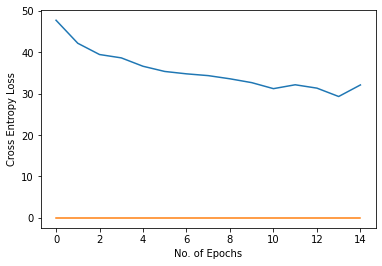

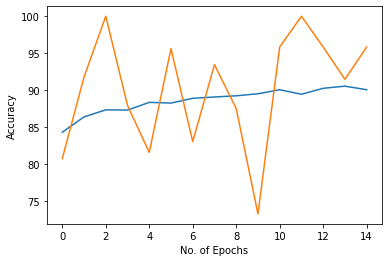

Finished Training


In [16]:
training_fun(vgg16,Epochs,optimizer,"new_vgg16_new",Criterion=criterion)

**Test On Validation Data**

In [0]:
from sklearn.metrics import multilabel_confusion_matrix

In [25]:
testing_fun(vgg16,validloader)

Accuracy  92.99363057324841
F1 Score  0.927754780905561
Covid19
  [[600   0]
 [ 18  10]]
Normal
   [[208  20]
 [ 13 387]]
Pneumonia
  [[386  14]
 [ 21 207]]


**Load Resnet18 Model**

In [27]:
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Sequential(
  nn.Linear(resnet.fc.in_features, 1050, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(1050, len(class_names), bias=True)
)
# Freeze training for all layers
for param in resnet.parameters():
    param.requires_grad = True 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


**Setting Hyper Parameters**

In [0]:
Epochs = 15
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

**Traing On Resnet18 WithOut Focal Loss**



0it [00:00, ?it/s]

Train Epoch: 0 [0/6200 (0%)]	Loss: 0.644814	Correct: 11	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 0 [0/6200 (0%)]	Loss: 0.644814	Correct: 11	Total: 32: : 1it [00:01,  1.25s/it]

Train Epoch: 0 [32/6200 (1%)]	Loss: 0.614273	Correct: 9	Total: 32: : 1it [00:01,  1.25s/it]

Train Epoch: 0 [32/6200 (1%)]	Loss: 0.614273	Correct: 9	Total: 32: : 2it [00:01,  1.09it/s]

Train Epoch: 0 [64/6200 (1%)]	Loss: 0.596537	Correct: 14	Total: 32: : 2it [00:02,  1.09it/s]

Train Epoch: 0 [64/6200 (1%)]	Loss: 0.596537	Correct: 14	Total: 32: : 3it [00:02,  1.04it/s]

Train Epoch: 0 [96/6200 (2%)]	Loss: 0.598075	Correct: 15	Total: 32: : 3it [00:02,  1.04it/s]

Train Epoch: 0 [96/6200 (2%)]	Loss: 0.598075	Correct: 15	Total: 32: : 4it [00:02,  1.41it/s]

Train Epoch: 0 [128/6200 (2%)]	Loss: 0.544651	Correct: 15	Total: 32: : 4it [00:03,  1.41it/s]

Train Epoch: 0 [128/6200 (2%)]	Loss: 0.544651	Correct: 15	Total: 32: : 5it [00:03,  1.27it/s]

Train Epoch: 0 [160/6200 (3%)]	Loss: 0.50274

Training Accuracy of Epoch 0: 69 %


Validation Accuracy of Epoch 0: 78 %




0it [00:00, ?it/s]

Train Epoch: 1 [0/6200 (0%)]	Loss: 0.238971	Correct: 26	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 1 [0/6200 (0%)]	Loss: 0.238971	Correct: 26	Total: 32: : 1it [00:01,  1.20s/it]

Train Epoch: 1 [32/6200 (1%)]	Loss: 0.471787	Correct: 24	Total: 32: : 1it [00:01,  1.20s/it]

Train Epoch: 1 [32/6200 (1%)]	Loss: 0.471787	Correct: 24	Total: 32: : 2it [00:01,  1.03s/it]

Train Epoch: 1 [64/6200 (1%)]	Loss: 0.303545	Correct: 26	Total: 32: : 2it [00:02,  1.03s/it]

Train Epoch: 1 [64/6200 (1%)]	Loss: 0.303545	Correct: 26	Total: 32: : 3it [00:02,  1.10it/s]

Train Epoch: 1 [96/6200 (2%)]	Loss: 0.295510	Correct: 29	Total: 32: : 3it [00:03,  1.10it/s]

Train Epoch: 1 [96/6200 (2%)]	Loss: 0.295510	Correct: 29	Total: 32: : 4it [00:03,  1.08it/s]

Train Epoch: 1 [128/6200 (2%)]	Loss: 0.238137	Correct: 27	Total: 32: : 4it [00:03,  1.08it/s]

Train Epoch: 1 [128/6200 (2%)]	Loss: 0.238137	Correct: 27	Total: 32: : 5it [00:03,  1.41it/s]

Train Epoch: 1 [160/6200 (3%)]	Loss: 0.363

Training Accuracy of Epoch 1: 82 %


Validation Accuracy of Epoch 1: 83 %




0it [00:00, ?it/s]

Train Epoch: 2 [0/6200 (0%)]	Loss: 0.229289	Correct: 29	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 2 [0/6200 (0%)]	Loss: 0.229289	Correct: 29	Total: 32: : 1it [00:01,  1.53s/it]

Train Epoch: 2 [32/6200 (1%)]	Loss: 0.240159	Correct: 26	Total: 32: : 1it [00:01,  1.53s/it]

Train Epoch: 2 [32/6200 (1%)]	Loss: 0.240159	Correct: 26	Total: 32: : 2it [00:01,  1.11s/it]

Train Epoch: 2 [64/6200 (1%)]	Loss: 0.257762	Correct: 26	Total: 32: : 2it [00:02,  1.11s/it]

Train Epoch: 2 [64/6200 (1%)]	Loss: 0.257762	Correct: 26	Total: 32: : 3it [00:02,  1.08s/it]

Train Epoch: 2 [96/6200 (2%)]	Loss: 0.254778	Correct: 25	Total: 32: : 3it [00:02,  1.08s/it]

Train Epoch: 2 [96/6200 (2%)]	Loss: 0.254778	Correct: 25	Total: 32: : 4it [00:02,  1.27it/s]

Train Epoch: 2 [128/6200 (2%)]	Loss: 0.246726	Correct: 25	Total: 32: : 4it [00:03,  1.27it/s]

Train Epoch: 2 [128/6200 (2%)]	Loss: 0.246726	Correct: 25	Total: 32: : 5it [00:03,  1.17it/s]

Train Epoch: 2 [160/6200 (3%)]	Loss: 0.278

Training Accuracy of Epoch 2: 84 %


Validation Accuracy of Epoch 2: 91 %




0it [00:00, ?it/s]

Train Epoch: 3 [0/6200 (0%)]	Loss: 0.332619	Correct: 26	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 3 [0/6200 (0%)]	Loss: 0.332619	Correct: 26	Total: 32: : 1it [00:01,  1.24s/it]

Train Epoch: 3 [32/6200 (1%)]	Loss: 0.230729	Correct: 28	Total: 32: : 1it [00:01,  1.24s/it]

Train Epoch: 3 [32/6200 (1%)]	Loss: 0.230729	Correct: 28	Total: 32: : 2it [00:01,  1.10it/s]

Train Epoch: 3 [64/6200 (1%)]	Loss: 0.141256	Correct: 29	Total: 32: : 2it [00:02,  1.10it/s]

Train Epoch: 3 [64/6200 (1%)]	Loss: 0.141256	Correct: 29	Total: 32: : 3it [00:02,  1.08it/s]

Train Epoch: 3 [96/6200 (2%)]	Loss: 0.194401	Correct: 26	Total: 32: : 3it [00:02,  1.08it/s]

Train Epoch: 3 [96/6200 (2%)]	Loss: 0.194401	Correct: 26	Total: 32: : 4it [00:02,  1.47it/s]

Train Epoch: 3 [128/6200 (2%)]	Loss: 0.115337	Correct: 30	Total: 32: : 4it [00:03,  1.47it/s]

Train Epoch: 3 [128/6200 (2%)]	Loss: 0.115337	Correct: 30	Total: 32: : 5it [00:03,  1.28it/s]

Train Epoch: 3 [160/6200 (3%)]	Loss: 0.229

Training Accuracy of Epoch 3: 85 %


Validation Accuracy of Epoch 3: 91 %




0it [00:00, ?it/s]

Train Epoch: 4 [0/6200 (0%)]	Loss: 0.284211	Correct: 24	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 4 [0/6200 (0%)]	Loss: 0.284211	Correct: 24	Total: 32: : 1it [00:01,  1.92s/it]

Train Epoch: 4 [32/6200 (1%)]	Loss: 0.264072	Correct: 28	Total: 32: : 1it [00:02,  1.92s/it]

Train Epoch: 4 [32/6200 (1%)]	Loss: 0.264072	Correct: 28	Total: 32: : 2it [00:02,  1.38s/it]

Train Epoch: 4 [64/6200 (1%)]	Loss: 0.162983	Correct: 29	Total: 32: : 2it [00:02,  1.38s/it]

Train Epoch: 4 [64/6200 (1%)]	Loss: 0.162983	Correct: 29	Total: 32: : 3it [00:02,  1.23s/it]

Train Epoch: 4 [96/6200 (2%)]	Loss: 0.114126	Correct: 29	Total: 32: : 3it [00:03,  1.23s/it]

Train Epoch: 4 [96/6200 (2%)]	Loss: 0.114126	Correct: 29	Total: 32: : 4it [00:03,  1.11it/s]

Train Epoch: 4 [128/6200 (2%)]	Loss: 0.209517	Correct: 26	Total: 32: : 4it [00:04,  1.11it/s]

Train Epoch: 4 [128/6200 (2%)]	Loss: 0.209517	Correct: 26	Total: 32: : 5it [00:04,  1.07it/s]

Train Epoch: 4 [160/6200 (3%)]	Loss: 0.180

Training Accuracy of Epoch 4: 86 %


Validation Accuracy of Epoch 4: 82 %




0it [00:00, ?it/s]

Train Epoch: 5 [0/6200 (0%)]	Loss: 0.134860	Correct: 29	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 5 [0/6200 (0%)]	Loss: 0.134860	Correct: 29	Total: 32: : 1it [00:01,  1.28s/it]

Train Epoch: 5 [32/6200 (1%)]	Loss: 0.167188	Correct: 28	Total: 32: : 1it [00:01,  1.28s/it]

Train Epoch: 5 [32/6200 (1%)]	Loss: 0.167188	Correct: 28	Total: 32: : 2it [00:01,  1.06it/s]

Train Epoch: 5 [64/6200 (1%)]	Loss: 0.136404	Correct: 30	Total: 32: : 2it [00:02,  1.06it/s]

Train Epoch: 5 [64/6200 (1%)]	Loss: 0.136404	Correct: 30	Total: 32: : 3it [00:02,  1.05it/s]

Train Epoch: 5 [96/6200 (2%)]	Loss: 0.124660	Correct: 28	Total: 32: : 3it [00:02,  1.05it/s]

Train Epoch: 5 [96/6200 (2%)]	Loss: 0.124660	Correct: 28	Total: 32: : 4it [00:02,  1.39it/s]

Train Epoch: 5 [128/6200 (2%)]	Loss: 0.234340	Correct: 27	Total: 32: : 4it [00:04,  1.39it/s]

Train Epoch: 5 [128/6200 (2%)]	Loss: 0.234340	Correct: 27	Total: 32: : 5it [00:04,  1.02s/it]

Train Epoch: 5 [160/6200 (3%)]	Loss: 0.170

Training Accuracy of Epoch 5: 86 %


Validation Accuracy of Epoch 5: 80 %




0it [00:00, ?it/s]

Train Epoch: 6 [0/6200 (0%)]	Loss: 0.282377	Correct: 26	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 6 [0/6200 (0%)]	Loss: 0.282377	Correct: 26	Total: 32: : 1it [00:01,  1.54s/it]

Train Epoch: 6 [32/6200 (1%)]	Loss: 0.306086	Correct: 24	Total: 32: : 1it [00:01,  1.54s/it]

Train Epoch: 6 [32/6200 (1%)]	Loss: 0.306086	Correct: 24	Total: 32: : 2it [00:01,  1.12s/it]

Train Epoch: 6 [64/6200 (1%)]	Loss: 0.258831	Correct: 24	Total: 32: : 2it [00:02,  1.12s/it]

Train Epoch: 6 [64/6200 (1%)]	Loss: 0.258831	Correct: 24	Total: 32: : 3it [00:02,  1.07s/it]

Train Epoch: 6 [96/6200 (2%)]	Loss: 0.225997	Correct: 28	Total: 32: : 3it [00:02,  1.07s/it]

Train Epoch: 6 [96/6200 (2%)]	Loss: 0.225997	Correct: 28	Total: 32: : 4it [00:02,  1.27it/s]

Train Epoch: 6 [128/6200 (2%)]	Loss: 0.278614	Correct: 30	Total: 32: : 4it [00:03,  1.27it/s]

Train Epoch: 6 [128/6200 (2%)]	Loss: 0.278614	Correct: 30	Total: 32: : 5it [00:03,  1.15it/s]

Train Epoch: 6 [160/6200 (3%)]	Loss: 0.159

Training Accuracy of Epoch 6: 87 %


Validation Accuracy of Epoch 6: 94 %




0it [00:00, ?it/s]

Train Epoch: 7 [0/6200 (0%)]	Loss: 0.215026	Correct: 26	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 7 [0/6200 (0%)]	Loss: 0.215026	Correct: 26	Total: 32: : 1it [00:01,  1.25s/it]

Train Epoch: 7 [32/6200 (1%)]	Loss: 0.196863	Correct: 29	Total: 32: : 1it [00:01,  1.25s/it]

Train Epoch: 7 [32/6200 (1%)]	Loss: 0.196863	Correct: 29	Total: 32: : 2it [00:01,  1.09it/s]

Train Epoch: 7 [64/6200 (1%)]	Loss: 0.175158	Correct: 28	Total: 32: : 2it [00:02,  1.09it/s]

Train Epoch: 7 [64/6200 (1%)]	Loss: 0.175158	Correct: 28	Total: 32: : 3it [00:02,  1.04it/s]

Train Epoch: 7 [96/6200 (2%)]	Loss: 0.163341	Correct: 29	Total: 32: : 3it [00:02,  1.04it/s]

Train Epoch: 7 [96/6200 (2%)]	Loss: 0.163341	Correct: 29	Total: 32: : 4it [00:02,  1.41it/s]

Train Epoch: 7 [128/6200 (2%)]	Loss: 0.106043	Correct: 30	Total: 32: : 4it [00:03,  1.41it/s]

Train Epoch: 7 [128/6200 (2%)]	Loss: 0.106043	Correct: 30	Total: 32: : 5it [00:03,  1.26it/s]

Train Epoch: 7 [160/6200 (3%)]	Loss: 0.107

Training Accuracy of Epoch 7: 87 %


Validation Accuracy of Epoch 7: 84 %




0it [00:00, ?it/s]

Train Epoch: 8 [0/6200 (0%)]	Loss: 0.177821	Correct: 29	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 8 [0/6200 (0%)]	Loss: 0.177821	Correct: 29	Total: 32: : 1it [00:01,  1.25s/it]

Train Epoch: 8 [32/6200 (1%)]	Loss: 0.090860	Correct: 31	Total: 32: : 1it [00:01,  1.25s/it]

Train Epoch: 8 [32/6200 (1%)]	Loss: 0.090860	Correct: 31	Total: 32: : 2it [00:01,  1.09it/s]

Train Epoch: 8 [64/6200 (1%)]	Loss: 0.127227	Correct: 27	Total: 32: : 2it [00:02,  1.09it/s]

Train Epoch: 8 [64/6200 (1%)]	Loss: 0.127227	Correct: 27	Total: 32: : 3it [00:02,  1.10it/s]

Train Epoch: 8 [96/6200 (2%)]	Loss: 0.312012	Correct: 25	Total: 32: : 3it [00:02,  1.10it/s]

Train Epoch: 8 [96/6200 (2%)]	Loss: 0.312012	Correct: 25	Total: 32: : 4it [00:02,  1.49it/s]

Train Epoch: 8 [128/6200 (2%)]	Loss: 0.083740	Correct: 31	Total: 32: : 4it [00:03,  1.49it/s]

Train Epoch: 8 [128/6200 (2%)]	Loss: 0.083740	Correct: 31	Total: 32: : 5it [00:03,  1.30it/s]

Train Epoch: 8 [160/6200 (3%)]	Loss: 0.181

Training Accuracy of Epoch 8: 87 %


Validation Accuracy of Epoch 8: 90 %




0it [00:00, ?it/s]

Train Epoch: 9 [0/6200 (0%)]	Loss: 0.102079	Correct: 30	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 9 [0/6200 (0%)]	Loss: 0.102079	Correct: 30	Total: 32: : 1it [00:01,  1.35s/it]

Train Epoch: 9 [32/6200 (1%)]	Loss: 0.098008	Correct: 32	Total: 32: : 1it [00:01,  1.35s/it]

Train Epoch: 9 [32/6200 (1%)]	Loss: 0.098008	Correct: 32	Total: 32: : 2it [00:01,  1.02it/s]

Train Epoch: 9 [64/6200 (1%)]	Loss: 0.463509	Correct: 24	Total: 32: : 2it [00:03,  1.02it/s]

Train Epoch: 9 [64/6200 (1%)]	Loss: 0.463509	Correct: 24	Total: 32: : 3it [00:03,  1.25s/it]

Train Epoch: 9 [96/6200 (2%)]	Loss: 0.176409	Correct: 30	Total: 32: : 3it [00:03,  1.25s/it]

Train Epoch: 9 [96/6200 (2%)]	Loss: 0.176409	Correct: 30	Total: 32: : 4it [00:03,  1.10it/s]

Train Epoch: 9 [128/6200 (2%)]	Loss: 0.265387	Correct: 25	Total: 32: : 4it [00:04,  1.10it/s]

Train Epoch: 9 [128/6200 (2%)]	Loss: 0.265387	Correct: 25	Total: 32: : 5it [00:04,  1.12it/s]

Train Epoch: 9 [160/6200 (3%)]	Loss: 0.174

Training Accuracy of Epoch 9: 88 %


Validation Accuracy of Epoch 9: 89 %




0it [00:00, ?it/s]

Train Epoch: 10 [0/6200 (0%)]	Loss: 0.210868	Correct: 28	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 10 [0/6200 (0%)]	Loss: 0.210868	Correct: 28	Total: 32: : 1it [00:01,  1.22s/it]

Train Epoch: 10 [32/6200 (1%)]	Loss: 0.143454	Correct: 29	Total: 32: : 1it [00:01,  1.22s/it]

Train Epoch: 10 [32/6200 (1%)]	Loss: 0.143454	Correct: 29	Total: 32: : 2it [00:01,  1.05it/s]

Train Epoch: 10 [64/6200 (1%)]	Loss: 0.150078	Correct: 28	Total: 32: : 2it [00:02,  1.05it/s]

Train Epoch: 10 [64/6200 (1%)]	Loss: 0.150078	Correct: 28	Total: 32: : 3it [00:02,  1.13it/s]

Train Epoch: 10 [96/6200 (2%)]	Loss: 0.268492	Correct: 26	Total: 32: : 3it [00:02,  1.13it/s]

Train Epoch: 10 [96/6200 (2%)]	Loss: 0.268492	Correct: 26	Total: 32: : 4it [00:02,  1.39it/s]

Train Epoch: 10 [128/6200 (2%)]	Loss: 0.222057	Correct: 29	Total: 32: : 4it [00:03,  1.39it/s]

Train Epoch: 10 [128/6200 (2%)]	Loss: 0.222057	Correct: 29	Total: 32: : 5it [00:03,  1.33it/s]

Train Epoch: 10 [160/6200 (3%)]	

Training Accuracy of Epoch 10: 88 %


Validation Accuracy of Epoch 10: 90 %




0it [00:00, ?it/s]

Train Epoch: 11 [0/6200 (0%)]	Loss: 0.054536	Correct: 32	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 11 [0/6200 (0%)]	Loss: 0.054536	Correct: 32	Total: 32: : 1it [00:01,  1.26s/it]

Train Epoch: 11 [32/6200 (1%)]	Loss: 0.145150	Correct: 29	Total: 32: : 1it [00:01,  1.26s/it]

Train Epoch: 11 [32/6200 (1%)]	Loss: 0.145150	Correct: 29	Total: 32: : 2it [00:01,  1.09it/s]

Train Epoch: 11 [64/6200 (1%)]	Loss: 0.208398	Correct: 28	Total: 32: : 2it [00:02,  1.09it/s]

Train Epoch: 11 [64/6200 (1%)]	Loss: 0.208398	Correct: 28	Total: 32: : 3it [00:02,  1.02s/it]

Train Epoch: 11 [96/6200 (2%)]	Loss: 0.166716	Correct: 30	Total: 32: : 3it [00:02,  1.02s/it]

Train Epoch: 11 [96/6200 (2%)]	Loss: 0.166716	Correct: 30	Total: 32: : 4it [00:02,  1.34it/s]

Train Epoch: 11 [128/6200 (2%)]	Loss: 0.100876	Correct: 31	Total: 32: : 4it [00:03,  1.34it/s]

Train Epoch: 11 [128/6200 (2%)]	Loss: 0.100876	Correct: 31	Total: 32: : 5it [00:03,  1.21it/s]

Train Epoch: 11 [160/6200 (3%)]	

Training Accuracy of Epoch 11: 89 %


Validation Accuracy of Epoch 11: 88 %




0it [00:00, ?it/s]

Train Epoch: 12 [0/6200 (0%)]	Loss: 0.113041	Correct: 29	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 12 [0/6200 (0%)]	Loss: 0.113041	Correct: 29	Total: 32: : 1it [00:01,  1.57s/it]

Train Epoch: 12 [32/6200 (1%)]	Loss: 0.227034	Correct: 26	Total: 32: : 1it [00:01,  1.57s/it]

Train Epoch: 12 [32/6200 (1%)]	Loss: 0.227034	Correct: 26	Total: 32: : 2it [00:01,  1.14s/it]

Train Epoch: 12 [64/6200 (1%)]	Loss: 0.216289	Correct: 27	Total: 32: : 2it [00:02,  1.14s/it]

Train Epoch: 12 [64/6200 (1%)]	Loss: 0.216289	Correct: 27	Total: 32: : 3it [00:02,  1.08s/it]

Train Epoch: 12 [96/6200 (2%)]	Loss: 0.165917	Correct: 27	Total: 32: : 3it [00:03,  1.08s/it]

Train Epoch: 12 [96/6200 (2%)]	Loss: 0.165917	Correct: 27	Total: 32: : 4it [00:03,  1.04it/s]

Train Epoch: 12 [128/6200 (2%)]	Loss: 0.173968	Correct: 30	Total: 32: : 4it [00:03,  1.04it/s]

Train Epoch: 12 [128/6200 (2%)]	Loss: 0.173968	Correct: 30	Total: 32: : 5it [00:03,  1.25it/s]

Train Epoch: 12 [160/6200 (3%)]	

Training Accuracy of Epoch 12: 88 %


Validation Accuracy of Epoch 12: 81 %




0it [00:00, ?it/s]

Train Epoch: 13 [0/6200 (0%)]	Loss: 0.271129	Correct: 26	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 13 [0/6200 (0%)]	Loss: 0.271129	Correct: 26	Total: 32: : 1it [00:01,  1.61s/it]

Train Epoch: 13 [32/6200 (1%)]	Loss: 0.239628	Correct: 26	Total: 32: : 1it [00:01,  1.61s/it]

Train Epoch: 13 [32/6200 (1%)]	Loss: 0.239628	Correct: 26	Total: 32: : 2it [00:01,  1.18s/it]

Train Epoch: 13 [64/6200 (1%)]	Loss: 0.189690	Correct: 28	Total: 32: : 2it [00:02,  1.18s/it]

Train Epoch: 13 [64/6200 (1%)]	Loss: 0.189690	Correct: 28	Total: 32: : 3it [00:02,  1.12s/it]

Train Epoch: 13 [96/6200 (2%)]	Loss: 0.233870	Correct: 29	Total: 32: : 3it [00:02,  1.12s/it]

Train Epoch: 13 [96/6200 (2%)]	Loss: 0.233870	Correct: 29	Total: 32: : 4it [00:02,  1.22it/s]

Train Epoch: 13 [128/6200 (2%)]	Loss: 0.196277	Correct: 28	Total: 32: : 4it [00:03,  1.22it/s]

Train Epoch: 13 [128/6200 (2%)]	Loss: 0.196277	Correct: 28	Total: 32: : 5it [00:03,  1.16it/s]

Train Epoch: 13 [160/6200 (3%)]	

Training Accuracy of Epoch 13: 89 %


Validation Accuracy of Epoch 13: 95 %




0it [00:00, ?it/s]

Train Epoch: 14 [0/6200 (0%)]	Loss: 0.156214	Correct: 27	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 14 [0/6200 (0%)]	Loss: 0.156214	Correct: 27	Total: 32: : 1it [00:01,  1.36s/it]

Train Epoch: 14 [32/6200 (1%)]	Loss: 0.141900	Correct: 28	Total: 32: : 1it [00:01,  1.36s/it]

Train Epoch: 14 [32/6200 (1%)]	Loss: 0.141900	Correct: 28	Total: 32: : 2it [00:01,  1.01it/s]

Train Epoch: 14 [64/6200 (1%)]	Loss: 0.157835	Correct: 28	Total: 32: : 2it [00:02,  1.01it/s]

Train Epoch: 14 [64/6200 (1%)]	Loss: 0.157835	Correct: 28	Total: 32: : 3it [00:02,  1.03it/s]

Train Epoch: 14 [96/6200 (2%)]	Loss: 0.123069	Correct: 28	Total: 32: : 3it [00:02,  1.03it/s]

Train Epoch: 14 [96/6200 (2%)]	Loss: 0.123069	Correct: 28	Total: 32: : 4it [00:02,  1.40it/s]

Train Epoch: 14 [128/6200 (2%)]	Loss: 0.104304	Correct: 30	Total: 32: : 4it [00:03,  1.40it/s]

Train Epoch: 14 [128/6200 (2%)]	Loss: 0.104304	Correct: 30	Total: 32: : 5it [00:03,  1.24it/s]

Train Epoch: 14 [160/6200 (3%)]	

Training Accuracy of Epoch 14: 89 %


Validation Accuracy of Epoch 14: 81 %


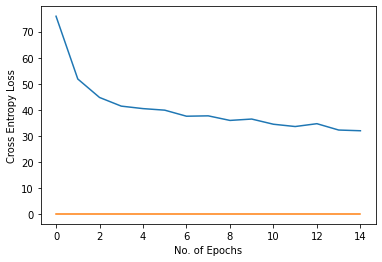

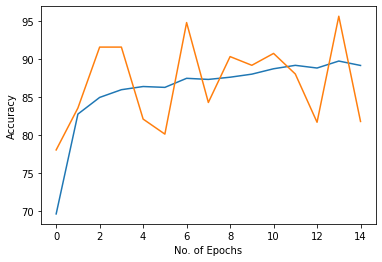

Finished Training


In [30]:
training_fun(resnet,Epochs,optimizer,"new_resnet_new",Criterion=criterion)

**Testing on Validation Data**

In [31]:
testing_fun(resnet,validloader)

Accuracy  91.87898089171975
F1 Score  0.9168906847439514
Covid19
  [[599   1]
 [ 15  13]]
Normal
   [[200  28]
 [ 15 385]]
Pneumonia
  [[385  15]
 [ 29 199]]


**Changing Weights of VGG16 For Focal_Loss Model**

In [0]:
vgg16 = models.vgg16(pretrained=False)
fl_neu_inp = vgg16.classifier[0].in_features
features = list(vgg16.classifier)[:-7]
features
features.extend(
    [
     nn.Linear(fl_neu_inp,1000),
     nn.ReLU(inplace=True),
     nn.Dropout(inplace=False),
     nn.Linear(1000, len(class_names))])
vgg16.classifier = nn.Sequential(*features)




**Setting Hyper Parameters**

In [0]:
Epochs = 10
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

**Training VGG16 With Focal Loss**



0it [00:00, ?it/s]

Train Epoch: 0 [0/6200 (0%)]	Loss: 0.172486	Correct: 0	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 0 [0/6200 (0%)]	Loss: 0.172486	Correct: 0	Total: 32: : 1it [00:01,  1.57s/it]

Train Epoch: 0 [32/6200 (1%)]	Loss: 0.172588	Correct: 2	Total: 32: : 1it [00:02,  1.57s/it]

Train Epoch: 0 [32/6200 (1%)]	Loss: 0.172588	Correct: 2	Total: 32: : 2it [00:02,  1.24s/it]

Train Epoch: 0 [64/6200 (1%)]	Loss: 0.170902	Correct: 4	Total: 32: : 2it [00:02,  1.24s/it]

Train Epoch: 0 [64/6200 (1%)]	Loss: 0.170902	Correct: 4	Total: 32: : 3it [00:02,  1.11s/it]

Train Epoch: 0 [96/6200 (2%)]	Loss: 0.171521	Correct: 2	Total: 32: : 3it [00:03,  1.11s/it]

Train Epoch: 0 [96/6200 (2%)]	Loss: 0.171521	Correct: 2	Total: 32: : 4it [00:03,  1.10it/s]

Train Epoch: 0 [128/6200 (2%)]	Loss: 0.170661	Correct: 4	Total: 32: : 4it [00:04,  1.10it/s]

Train Epoch: 0 [128/6200 (2%)]	Loss: 0.170661	Correct: 4	Total: 32: : 5it [00:04,  1.03it/s]

Train Epoch: 0 [160/6200 (3%)]	Loss: 0.170430	Correc

Training Accuracy of Epoch 0: 62 %


Validation Accuracy of Epoch 0: 70 %




0it [00:00, ?it/s]

Train Epoch: 1 [0/6200 (0%)]	Loss: 0.064082	Correct: 19	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 1 [0/6200 (0%)]	Loss: 0.064082	Correct: 19	Total: 32: : 1it [00:01,  1.49s/it]

Train Epoch: 1 [32/6200 (1%)]	Loss: 0.071467	Correct: 15	Total: 32: : 1it [00:01,  1.49s/it]

Train Epoch: 1 [32/6200 (1%)]	Loss: 0.071467	Correct: 15	Total: 32: : 2it [00:01,  1.18s/it]

Train Epoch: 1 [64/6200 (1%)]	Loss: 0.038001	Correct: 25	Total: 32: : 2it [00:02,  1.18s/it]

Train Epoch: 1 [64/6200 (1%)]	Loss: 0.038001	Correct: 25	Total: 32: : 3it [00:02,  1.08s/it]

Train Epoch: 1 [96/6200 (2%)]	Loss: 0.052503	Correct: 20	Total: 32: : 3it [00:03,  1.08s/it]

Train Epoch: 1 [96/6200 (2%)]	Loss: 0.052503	Correct: 20	Total: 32: : 4it [00:03,  1.13it/s]

Train Epoch: 1 [128/6200 (2%)]	Loss: 0.064917	Correct: 20	Total: 32: : 4it [00:04,  1.13it/s]

Train Epoch: 1 [128/6200 (2%)]	Loss: 0.064917	Correct: 20	Total: 32: : 5it [00:04,  1.05it/s]

Train Epoch: 1 [160/6200 (3%)]	Loss: 0.051

Training Accuracy of Epoch 1: 63 %


Validation Accuracy of Epoch 1: 64 %




0it [00:00, ?it/s]

Train Epoch: 2 [0/6200 (0%)]	Loss: 0.066121	Correct: 21	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 2 [0/6200 (0%)]	Loss: 0.066121	Correct: 21	Total: 32: : 1it [00:01,  1.66s/it]

Train Epoch: 2 [32/6200 (1%)]	Loss: 0.042461	Correct: 22	Total: 32: : 1it [00:02,  1.66s/it]

Train Epoch: 2 [32/6200 (1%)]	Loss: 0.042461	Correct: 22	Total: 32: : 2it [00:02,  1.30s/it]

Train Epoch: 2 [64/6200 (1%)]	Loss: 0.096818	Correct: 16	Total: 32: : 2it [00:02,  1.30s/it]

Train Epoch: 2 [64/6200 (1%)]	Loss: 0.096818	Correct: 16	Total: 32: : 3it [00:02,  1.15s/it]

Train Epoch: 2 [96/6200 (2%)]	Loss: 0.093236	Correct: 20	Total: 32: : 3it [00:03,  1.15s/it]

Train Epoch: 2 [96/6200 (2%)]	Loss: 0.093236	Correct: 20	Total: 32: : 4it [00:03,  1.06it/s]

Train Epoch: 2 [128/6200 (2%)]	Loss: 0.064436	Correct: 17	Total: 32: : 4it [00:04,  1.06it/s]

Train Epoch: 2 [128/6200 (2%)]	Loss: 0.064436	Correct: 17	Total: 32: : 5it [00:04,  1.09it/s]

Train Epoch: 2 [160/6200 (3%)]	Loss: 0.072

Training Accuracy of Epoch 2: 64 %


Validation Accuracy of Epoch 2: 62 %




0it [00:00, ?it/s]

Train Epoch: 3 [0/6200 (0%)]	Loss: 0.061924	Correct: 20	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 3 [0/6200 (0%)]	Loss: 0.061924	Correct: 20	Total: 32: : 1it [00:01,  1.54s/it]

Train Epoch: 3 [32/6200 (1%)]	Loss: 0.095434	Correct: 17	Total: 32: : 1it [00:02,  1.54s/it]

Train Epoch: 3 [32/6200 (1%)]	Loss: 0.095434	Correct: 17	Total: 32: : 2it [00:02,  1.24s/it]

Train Epoch: 3 [64/6200 (1%)]	Loss: 0.049027	Correct: 20	Total: 32: : 2it [00:02,  1.24s/it]

Train Epoch: 3 [64/6200 (1%)]	Loss: 0.049027	Correct: 20	Total: 32: : 3it [00:02,  1.08s/it]

Train Epoch: 3 [96/6200 (2%)]	Loss: 0.057435	Correct: 17	Total: 32: : 3it [00:03,  1.08s/it]

Train Epoch: 3 [96/6200 (2%)]	Loss: 0.057435	Correct: 17	Total: 32: : 4it [00:03,  1.08it/s]

Train Epoch: 3 [128/6200 (2%)]	Loss: 0.049191	Correct: 22	Total: 32: : 4it [00:04,  1.08it/s]

Train Epoch: 3 [128/6200 (2%)]	Loss: 0.049191	Correct: 22	Total: 32: : 5it [00:04,  1.15it/s]

Train Epoch: 3 [160/6200 (3%)]	Loss: 0.044

Training Accuracy of Epoch 3: 64 %


Validation Accuracy of Epoch 3: 68 %




0it [00:00, ?it/s]

Train Epoch: 4 [0/6200 (0%)]	Loss: 0.070980	Correct: 17	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 4 [0/6200 (0%)]	Loss: 0.070980	Correct: 17	Total: 32: : 1it [00:01,  1.52s/it]

Train Epoch: 4 [32/6200 (1%)]	Loss: 0.080677	Correct: 20	Total: 32: : 1it [00:01,  1.52s/it]

Train Epoch: 4 [32/6200 (1%)]	Loss: 0.080677	Correct: 20	Total: 32: : 2it [00:01,  1.20s/it]

Train Epoch: 4 [64/6200 (1%)]	Loss: 0.075909	Correct: 20	Total: 32: : 2it [00:02,  1.20s/it]

Train Epoch: 4 [64/6200 (1%)]	Loss: 0.075909	Correct: 20	Total: 32: : 3it [00:02,  1.08s/it]

Train Epoch: 4 [96/6200 (2%)]	Loss: 0.078296	Correct: 22	Total: 32: : 3it [00:03,  1.08s/it]

Train Epoch: 4 [96/6200 (2%)]	Loss: 0.078296	Correct: 22	Total: 32: : 4it [00:03,  1.04it/s]

Train Epoch: 4 [128/6200 (2%)]	Loss: 0.044394	Correct: 20	Total: 32: : 4it [00:04,  1.04it/s]

Train Epoch: 4 [128/6200 (2%)]	Loss: 0.044394	Correct: 20	Total: 32: : 5it [00:04,  1.16it/s]

Train Epoch: 4 [160/6200 (3%)]	Loss: 0.098

Training Accuracy of Epoch 4: 64 %


Validation Accuracy of Epoch 4: 70 %




0it [00:00, ?it/s]

Train Epoch: 5 [0/6200 (0%)]	Loss: 0.075546	Correct: 18	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 5 [0/6200 (0%)]	Loss: 0.075546	Correct: 18	Total: 32: : 1it [00:01,  1.79s/it]

Train Epoch: 5 [32/6200 (1%)]	Loss: 0.100986	Correct: 16	Total: 32: : 1it [00:02,  1.79s/it]

Train Epoch: 5 [32/6200 (1%)]	Loss: 0.100986	Correct: 16	Total: 32: : 2it [00:02,  1.39s/it]

Train Epoch: 5 [64/6200 (1%)]	Loss: 0.037456	Correct: 23	Total: 32: : 2it [00:02,  1.39s/it]

Train Epoch: 5 [64/6200 (1%)]	Loss: 0.037456	Correct: 23	Total: 32: : 3it [00:02,  1.19s/it]

Train Epoch: 5 [96/6200 (2%)]	Loss: 0.039537	Correct: 25	Total: 32: : 3it [00:03,  1.19s/it]

Train Epoch: 5 [96/6200 (2%)]	Loss: 0.039537	Correct: 25	Total: 32: : 4it [00:03,  1.03it/s]

Train Epoch: 5 [128/6200 (2%)]	Loss: 0.054614	Correct: 22	Total: 32: : 4it [00:04,  1.03it/s]

Train Epoch: 5 [128/6200 (2%)]	Loss: 0.054614	Correct: 22	Total: 32: : 5it [00:04,  1.04it/s]

Train Epoch: 5 [160/6200 (3%)]	Loss: 0.048

Training Accuracy of Epoch 5: 66 %


Validation Accuracy of Epoch 5: 62 %




0it [00:00, ?it/s]

Train Epoch: 6 [0/6200 (0%)]	Loss: 0.063038	Correct: 21	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 6 [0/6200 (0%)]	Loss: 0.063038	Correct: 21	Total: 32: : 1it [00:01,  1.54s/it]

Train Epoch: 6 [32/6200 (1%)]	Loss: 0.025589	Correct: 27	Total: 32: : 1it [00:01,  1.54s/it]

Train Epoch: 6 [32/6200 (1%)]	Loss: 0.025589	Correct: 27	Total: 32: : 2it [00:02,  1.22s/it]

Train Epoch: 6 [64/6200 (1%)]	Loss: 0.098572	Correct: 19	Total: 32: : 2it [00:03,  1.22s/it]

Train Epoch: 6 [64/6200 (1%)]	Loss: 0.098572	Correct: 19	Total: 32: : 3it [00:03,  1.16s/it]

Train Epoch: 6 [96/6200 (2%)]	Loss: 0.032117	Correct: 25	Total: 32: : 3it [00:03,  1.16s/it]

Train Epoch: 6 [96/6200 (2%)]	Loss: 0.032117	Correct: 25	Total: 32: : 4it [00:03,  1.06it/s]

Train Epoch: 6 [128/6200 (2%)]	Loss: 0.031802	Correct: 23	Total: 32: : 4it [00:04,  1.06it/s]

Train Epoch: 6 [128/6200 (2%)]	Loss: 0.031802	Correct: 23	Total: 32: : 5it [00:04,  1.10it/s]

Train Epoch: 6 [160/6200 (3%)]	Loss: 0.053

Training Accuracy of Epoch 6: 67 %


Validation Accuracy of Epoch 6: 88 %




0it [00:00, ?it/s]

Train Epoch: 7 [0/6200 (0%)]	Loss: 0.069392	Correct: 22	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 7 [0/6200 (0%)]	Loss: 0.069392	Correct: 22	Total: 32: : 1it [00:01,  1.50s/it]

Train Epoch: 7 [32/6200 (1%)]	Loss: 0.090956	Correct: 17	Total: 32: : 1it [00:01,  1.50s/it]

Train Epoch: 7 [32/6200 (1%)]	Loss: 0.090956	Correct: 17	Total: 32: : 2it [00:01,  1.18s/it]

Train Epoch: 7 [64/6200 (1%)]	Loss: 0.031411	Correct: 25	Total: 32: : 2it [00:02,  1.18s/it]

Train Epoch: 7 [64/6200 (1%)]	Loss: 0.031411	Correct: 25	Total: 32: : 3it [00:02,  1.06s/it]

Train Epoch: 7 [96/6200 (2%)]	Loss: 0.063801	Correct: 17	Total: 32: : 3it [00:03,  1.06s/it]

Train Epoch: 7 [96/6200 (2%)]	Loss: 0.063801	Correct: 17	Total: 32: : 4it [00:03,  1.14it/s]

Train Epoch: 7 [128/6200 (2%)]	Loss: 0.051687	Correct: 23	Total: 32: : 4it [00:04,  1.14it/s]

Train Epoch: 7 [128/6200 (2%)]	Loss: 0.051687	Correct: 23	Total: 32: : 5it [00:04,  1.12it/s]

Train Epoch: 7 [160/6200 (3%)]	Loss: 0.041

Training Accuracy of Epoch 7: 67 %


Validation Accuracy of Epoch 7: 69 %




0it [00:00, ?it/s]

Train Epoch: 8 [0/6200 (0%)]	Loss: 0.049091	Correct: 25	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 8 [0/6200 (0%)]	Loss: 0.049091	Correct: 25	Total: 32: : 1it [00:01,  1.51s/it]

Train Epoch: 8 [32/6200 (1%)]	Loss: 0.073366	Correct: 17	Total: 32: : 1it [00:01,  1.51s/it]

Train Epoch: 8 [32/6200 (1%)]	Loss: 0.073366	Correct: 17	Total: 32: : 2it [00:01,  1.19s/it]

Train Epoch: 8 [64/6200 (1%)]	Loss: 0.050637	Correct: 20	Total: 32: : 2it [00:02,  1.19s/it]

Train Epoch: 8 [64/6200 (1%)]	Loss: 0.050637	Correct: 20	Total: 32: : 3it [00:02,  1.08s/it]

Train Epoch: 8 [96/6200 (2%)]	Loss: 0.044878	Correct: 23	Total: 32: : 3it [00:03,  1.08s/it]

Train Epoch: 8 [96/6200 (2%)]	Loss: 0.044878	Correct: 23	Total: 32: : 4it [00:03,  1.12it/s]

Train Epoch: 8 [128/6200 (2%)]	Loss: 0.060789	Correct: 20	Total: 32: : 4it [00:04,  1.12it/s]

Train Epoch: 8 [128/6200 (2%)]	Loss: 0.060789	Correct: 20	Total: 32: : 5it [00:04,  1.12it/s]

Train Epoch: 8 [160/6200 (3%)]	Loss: 0.056

Training Accuracy of Epoch 8: 67 %


Validation Accuracy of Epoch 8: 66 %




0it [00:00, ?it/s]

Train Epoch: 9 [0/6200 (0%)]	Loss: 0.045907	Correct: 23	Total: 32: : 0it [00:01, ?it/s]

Train Epoch: 9 [0/6200 (0%)]	Loss: 0.045907	Correct: 23	Total: 32: : 1it [00:01,  1.58s/it]

Train Epoch: 9 [32/6200 (1%)]	Loss: 0.045626	Correct: 23	Total: 32: : 1it [00:02,  1.58s/it]

Train Epoch: 9 [32/6200 (1%)]	Loss: 0.045626	Correct: 23	Total: 32: : 2it [00:02,  1.24s/it]

Train Epoch: 9 [64/6200 (1%)]	Loss: 0.044642	Correct: 20	Total: 32: : 2it [00:02,  1.24s/it]

Train Epoch: 9 [64/6200 (1%)]	Loss: 0.044642	Correct: 20	Total: 32: : 3it [00:02,  1.11s/it]

Train Epoch: 9 [96/6200 (2%)]	Loss: 0.072902	Correct: 19	Total: 32: : 3it [00:03,  1.11s/it]

Train Epoch: 9 [96/6200 (2%)]	Loss: 0.072902	Correct: 19	Total: 32: : 4it [00:03,  1.10it/s]

Train Epoch: 9 [128/6200 (2%)]	Loss: 0.053704	Correct: 22	Total: 32: : 4it [00:04,  1.10it/s]

Train Epoch: 9 [128/6200 (2%)]	Loss: 0.053704	Correct: 22	Total: 32: : 5it [00:04,  1.08it/s]

Train Epoch: 9 [160/6200 (3%)]	Loss: 0.037

Training Accuracy of Epoch 9: 68 %


Validation Accuracy of Epoch 9: 67 %


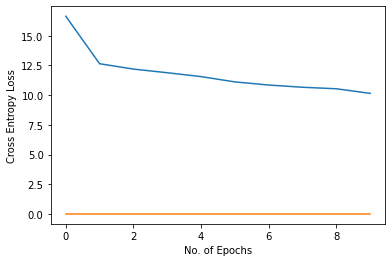

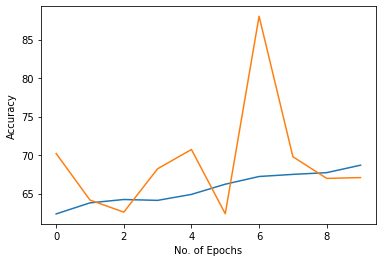

Finished Training


In [34]:
training_fun(vgg16,Epochs,optimizer,"resnet_new",isFocal=True)

**Testing On Validation Data**

In [35]:
testing_fun(vgg16,validloader)

Accuracy  76.11464968152866
F1 Score  0.72623233144383
Covid19
  [[600   0]
 [ 28   0]]
Normal
   [[105 123]
 [ 16 384]]
Pneumonia
  [[383  17]
 [122 106]]


**Changing Weights of Resnet18 for tarining with Focal Loss**

**Saving Predicted Into csv File**

In [0]:
import pandas as pd
df = pd.DataFrame(predicted_labels)
df.to_csv('MSDS19086_results.csv')